# Imports

In [ ]:
!git clone https://github.com/ultralytics/yolov5  
!pip install -U -r yolov5/requirements.txt

In [1]:
import os
import glob
import pandas as pd
import shutil
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import torch
#from utils.utils import plot_results

# Split data : train / val / test

In [2]:
train_df = pd.read_csv('./raw/train.csv')
test_df = pd.read_csv('./raw/test.csv')


############ SAMPLE ##################################################
# train_df = pd.concat([train_df[train_df['class'] == 0].head(50) , train_df[train_df['class'] == 1].head(50) ,
#                      train_df[train_df['class'] == 2].head(50) , train_df[train_df['class'] == 3].head(50) ,
#                      train_df[train_df['class'] == 4].head(50) , train_df[train_df['class'] == 5].head(50),
#                     train_df[train_df['class'] == 6].head(50) ,
#                     train_df[train_df['class'] == 7].head(50) , train_df[train_df['class'] == 8].head(50) ,
#                      train_df[train_df['class'] == 9].head(50) , train_df[train_df['class'] == 10].head(50)
#                      ])

# test_df = test_df.sample(frac=1)
# test_df = test_df[:200]
#########################################################################
 


images_dir = './raw/images'
train_dir = './dataset/train/images'
val_dir = './dataset/val/images'
test_dir = './dataset/test/images'

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)

os.mkdir(train_dir)

for image in train_df.image_path.unique():
    shutil.copyfile(os.path.join(images_dir, image), os.path.join(train_dir, image))
    

if os.path.exists(test_dir):
    shutil.rmtree(test_dir)

os.mkdir(test_dir)

for image in test_df.image_path.unique():
    shutil.copyfile(os.path.join(images_dir, image), os.path.join(test_dir, image))

if os.path.exists(val_dir):
    shutil.rmtree(val_dir)

os.mkdir(val_dir)

train_images = os.listdir(train_dir)
val_images = train_images[len(train_images) - int(len(train_images) * 0.33) : ]
for image in val_images:
    shutil.move(os.path.join(train_dir, image), os.path.join(val_dir, image))

val_df = train_df[train_df.image_path.isin(val_images)]
train_df = train_df[~train_df.image_path.isin(val_images)]

val_df = val_df.reset_index()
train_df = train_df.reset_index()

del val_df['index']
del train_df['index']


# Get classes

In [4]:
classes = train_df.drop_duplicates('name').sort_values(by='class').reset_index()
classes = classes[['name', 'class']]
classes

,name,class
0,GRAFFITI,0.0
1,FADED_SIGNAGE,1.0
2,POTHOLES,2.0
3,GARBAGE,3.0
4,CONSTRUCTION_ROAD,4.0
5,BROKEN_SIGNAGE,5.0
6,BAD_STREETLIGHT,6.0
7,BAD_BILLBOARD,7.0
8,SAND_ON_ROAD,8.0
9,CLUTTER_SIDEWALK,9.0


In [5]:
classes_context = '['
for c in classes['name'].values:
    classes_context =  classes_context +  "'" + c + "', "
classes_context = classes_context[:-2]
classes_context = classes_context + ']'
classes_context

"['GRAFFITI', 'FADED_SIGNAGE', 'POTHOLES', 'GARBAGE', 'CONSTRUCTION_ROAD', 'BROKEN_SIGNAGE', 'BAD_STREETLIGHT', 'BAD_BILLBOARD', 'SAND_ON_ROAD', 'CLUTTER_SIDEWALK', 'UNKEPT_FACADE']"

# Convert dimensions

In [6]:
def convert_dimensions(path=train_dir, df=train_df):
    xs = [] 
    ys = [] 
    ws = [] 
    hs = []
    heights = []
    widths = []
    
    df = df.reset_index()
    for i in df.index:
        image = Image.open(os.path.join(path,df.iloc[i].image_path))
        height = image.height
        width = image.width
        
        xmax = df.iloc[i].xmax #* 2
        xmin = df.iloc[i].xmin #* 2
        ymax = df.iloc[i].ymax #* 2
        ymin = df.iloc[i].ymin #* 2
        
        x = ((xmax + xmin) / (2 * width))
        y = ((ymax + ymin) / (2 * height))
        w = (xmax - xmin) / width
        h = (ymax - ymin) / height
        
        xs.append(x)
        ys.append(y)
        ws.append(w)
        hs.append(h)
        
        heights.append(height)
        widths.append(width)
    
    return (xs, ys, ws, hs, widths, heights)

In [7]:
#train_df = pd.read_csv('./raw/train.csv')
train_df.ymin = train_df.ymin * 2
train_df.ymax = train_df.ymax * 2
train_df.xmin = train_df.xmin * 2
train_df.xmax = train_df.xmax * 2
new_training_dimensions = convert_dimensions()

In [8]:
train_df['x'] = new_training_dimensions[0]
train_df['y'] = new_training_dimensions[1]
train_df['w'] = new_training_dimensions[2]
train_df['h'] = new_training_dimensions[3]

train_df['width'] = new_training_dimensions[4]
train_df['height'] = new_training_dimensions[5]

In [9]:
train_df.head()

,class,image_path,name,xmax,xmin,ymax,ymin,x,y,w,h,width,height
0,0.0,8ca1b825716ea6755180fde347ac79c1.jpg,GRAFFITI,1098.0,942.0,354.0,262.0,0.531250,0.285185,0.081250,0.085185,1920,1080
1,0.0,8ca1b825716ea6755180fde347ac79c1.jpg,GRAFFITI,1334.0,1130.0,364.0,246.0,0.641667,0.282407,0.106250,0.109259,1920,1080
2,0.0,4218ea76033c0d0612ba5d68bdcacaa7.jpg,GRAFFITI,1460.0,1040.0,468.0,288.0,0.651042,0.350000,0.218750,0.166667,1920,1080
3,0.0,38e6551fd3fc84bba6248723aa3a0744.jpg,GRAFFITI,756.0,530.0,592.0,462.0,0.334896,0.487963,0.117708,0.120370,1920,1080
4,0.0,68dee6cb43cbc7680c69a309992f947a.jpg,GRAFFITI,414.0,172.0,440.0,266.0,0.152604,0.326852,0.126042,0.161111,1920,1080


In [10]:
train_df.shape

(340, 13)

In [11]:
val_df.ymin = val_df.ymin * 2
val_df.ymax = val_df.ymax * 2
val_df.xmin = val_df.xmin * 2
val_df.xmax = val_df.xmax * 2
new_val_dimensions = convert_dimensions(path=val_dir, df=val_df)

In [12]:
val_df['x'] = new_val_dimensions[0]
val_df['y'] = new_val_dimensions[1]
val_df['w'] = new_val_dimensions[2]
val_df['h'] = new_val_dimensions[3]

val_df['width'] = new_val_dimensions[4]
val_df['height'] = new_val_dimensions[5]

In [13]:
val_df.head()

,class,image_path,name,xmax,xmin,ymax,ymin,x,y,w,h,width,height
0,0.0,beb51ff57e6429ea85c715e5b381deeb.jpg,GRAFFITI,1992.0,1536.0,380.0,64.0,0.918750,0.205556,0.237500,0.292593,1920,1080
1,0.0,df61a2072657c6babd6d3f68cffbdf2e.jpg,GRAFFITI,1930.0,1650.0,484.0,328.0,0.932292,0.375926,0.145833,0.144444,1920,1080
2,0.0,b079df7a0c498c361028fc7e97e31034.jpg,GRAFFITI,1428.0,1252.0,480.0,306.0,0.697917,0.363889,0.091667,0.161111,1920,1080
3,0.0,f60f46f4ad0735d5ea79a9e0d91cfb39.jpg,GRAFFITI,936.0,700.0,370.0,238.0,0.426042,0.281481,0.122917,0.122222,1920,1080
4,0.0,f60f46f4ad0735d5ea79a9e0d91cfb39.jpg,GRAFFITI,1026.0,854.0,350.0,246.0,0.489583,0.275926,0.089583,0.096296,1920,1080


# Object detection (random)

In [45]:
def object_detection_random(df=train_df, path=train_dir, count=1):
    counter = 0 
    df = df[df.image_path=='4255fa84582ba207069d415202d520ae.jpg']
    df = df.sample(frac=1)
    for image_path in df.image_path.unique():
        select_df = df[df.image_path == image_path].reset_index()
        del select_df['index']
        
        image = cv2.cvtColor(cv2.imread(os.path.join(path, image_path)), cv2.COLOR_BGR2RGB)
        for i in select_df.index:
            xmin = select_df.iloc[i].xmin #* 2
            ymin = select_df.iloc[i].ymin #* 2
            xmax = select_df.iloc[i].xmax #* 2
            ymax = select_df.iloc[i].ymax #* 2
            height = select_df.iloc[i].height
            width = select_df.iloc[i].width
            label = select_df.iloc[i]['name']
            
            print('class:' , select_df.iloc[i]['name'])
            print('xmin:' , xmin)
            print('ymin:' , ymin)
            print('xmax:' , xmax)
            print('ymax:' , ymax)
            print('----------------------------')
            
            cv2.rectangle(image,
                          (int(xmin) , int(ymin) ),
                          (int(xmax) , int(ymax) ),
                          (0,255,0), thickness=2)
            
            ((label_width, label_height), _) = cv2.getTextSize(label, fontFace=cv2.FONT_HERSHEY_PLAIN, 
            fontScale=1.75, thickness=2)
            
            cv2.rectangle(
      image,
          (int(xmin) , int(ymin)),
          (int(xmin + label_width + label_width * 0.05), int(ymin + label_height + label_height * 0.25)),
          color=(255, 0, 0),
          thickness=cv2.FILLED
        )
            
            cv2.putText(
          image,
          label,
          org=(int(xmin), int(ymin + label_height + label_height * 0.25)), 
          fontFace=cv2.FONT_HERSHEY_PLAIN,
          fontScale=1.75,
          color=(255, 255, 255),
          thickness=2 )
            
            plt.imshow(image)
        
        counter = counter + 1
        if count != None and count > 0 and counter >= count:
            break
            


In [46]:
train_df[train_df['class'] == 2]

,class,image_path,name,xmax,xmin,ymax,ymin,x,y,w,h,width,height
67,2.0,3fe43374bd1816998ad96704da640c60.jpg,POTHOLES,1796.0,758.0,1052.0,624.0,0.665104,0.775926,0.540625,0.396296,1920,1080
68,2.0,3fe43374bd1816998ad96704da640c60.jpg,POTHOLES,462.0,-106.0,1150.0,764.0,0.092708,0.886111,0.295833,0.357407,1920,1080
69,2.0,3fe43374bd1816998ad96704da640c60.jpg,POTHOLES,644.0,310.0,1080.0,900.0,0.248438,0.916667,0.173958,0.166667,1920,1080
70,2.0,55d207b4843a5d0334dd3c8bbe4fe616.jpg,POTHOLES,1510.0,640.0,1134.0,630.0,0.559896,0.816667,0.453125,0.466667,1920,1080
71,2.0,55d207b4843a5d0334dd3c8bbe4fe616.jpg,POTHOLES,850.0,6.0,1062.0,588.0,0.222917,0.763889,0.439583,0.438889,1920,1080
72,2.0,55d207b4843a5d0334dd3c8bbe4fe616.jpg,POTHOLES,930.0,620.0,966.0,622.0,0.403646,0.735185,0.161458,0.318519,1920,1080
73,2.0,55d207b4843a5d0334dd3c8bbe4fe616.jpg,POTHOLES,1572.0,1132.0,1140.0,736.0,0.704167,0.868519,0.229167,0.374074,1920,1080
74,2.0,82316aaeafc6a37767657489875238b4.jpg,POTHOLES,712.0,90.0,1002.0,692.0,0.208854,0.784259,0.323958,0.287037,1920,1080
75,2.0,82316aaeafc6a37767657489875238b4.jpg,POTHOLES,1516.0,786.0,1120.0,750.0,0.599479,0.865741,0.380208,0.342593,1920,1080
76,2.0,91cdd59f70c6439fe7d5971effd124a7.jpg,POTHOLES,652.0,86.0,944.0,602.0,0.192188,0.715741,0.294792,0.316667,1920,1080


class: POTHOLES
xmin: 796.0
ymin: 492.0
xmax: 1050.0
ymax: 838.0
----------------------------


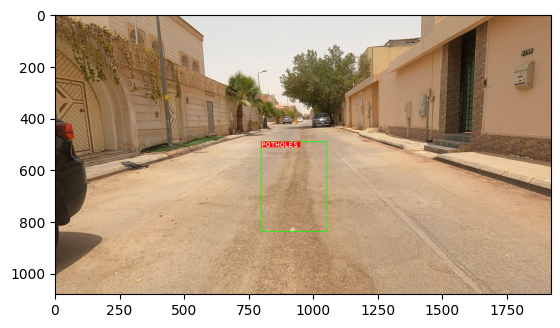

In [47]:
object_detection_random()

In [48]:
object_detection_random(df=val_df, path=val_dir, count=1)

# Label files

In [ ]:
def create_labels(df=train_df, path='./dataset/train/labels'):
    
    if os.path.exists(path):
        shutil.rmtree(path)
        
    os.mkdir(path)
    
    df = df.reset_index()
    for i in df.index:
        _class = df.iloc[i]['class']
        file_name = df.iloc[i].image_path.split('.')[0] + '.txt'
        x = df.iloc[i].x
        y = df.iloc[i].y
        w = df.iloc[i].w
        h = df.iloc[i].h
        
        content = '{} {} {} {} {}\n'
        content = content.format(_class, x, y, w, h)
        
        f = open(os.path.join(path, file_name) , 'a')
        f.write(content)
        f.close()

In [ ]:
create_labels()

In [ ]:
create_labels(val_df, './dataset/val/labels')

# Create config files

In [ ]:
dataset_config_text = """train: {}
val : {}
nc: {}
names: {}
"""

dataset_config_text = dataset_config_text.format('../' + train_dir, '../' + val_dir, classes['name'].nunique(), classes_context)

f = open('./yolov5/dataset_config.yaml', 'w')
f.write(dataset_config_text)
f.close()


In [ ]:
model_config_text = """# parameters
nc: {}  # number of classes  # CHANGED HERE
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]
"""

model_config_text = model_config_text.format(classes['name'].nunique())

f = open('./yolov5/model_config.yaml', 'w')
f.write(model_config_text)
f.close()

# Train model

In [1]:
!python yolov5/train.py --img 768  --epochs 50 --data yolov5/dataset_config.yaml --weights yolov5/yolov5l.pt --cache --workers 16

train: weights=yolov5/yolov5l.pt, cfg=, data=yolov5/dataset_config.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=16, imgsz=768, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=16, project=yolov5/runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-70-g589edc7 Python-3.8.10 torch-1.13.1+cu117 CUDA:0 (NVIDIA A100-SXM4-40GB, 40396MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, f

# Test model

In [63]:
#!python yolov5/detect.py --weights yolov5/runs/train/l/weights/best.pt --img 768 --conf 0.4 --source dataset/test/images

In [71]:
weight_path = 'yolov5/runs/train/l/weights/best.pt'
model = torch.hub.load('yolov5', 'custom', path=weight_path, source='local') 
final_output = pd.DataFrame()

for image in test_df.image_path:
    results = model(os.path.join(test_dir,image))
    output = results.pandas().xyxy[0]
    output['image_path'] = image
    final_output = pd.concat([final_output, output])

final_output = final_output[['class','image_path','name','xmax','xmin','ymax','ymin']]
final_output.to_csv('results.csv', index=False, encoding='utf-8-sig')